In [8]:
library(dplyr)
library(stringr)
library(readr)
library(tidyr)
library(lfe)
library(ggplot2)


In [9]:
### Loading Data
fp <- '/nfs/sloanlab004/projects/covid_mobility_proj/data/'
load('county_mobility_dvs.Rdata')
safegraph <- read_csv(str_c(fp, 'safegraph_social_distancing_aggregate_county.csv'))
counties_long <- read_csv(str_c(fp, 'county_policy_long.csv'))
countyInfo <- read_csv(str_c(fp, 'countyInfo.csv'))
weather <- read_csv(str_c(fp, 'county_weather.csv'))
voteShare <- read_csv(str_c(fp, 'county_vote_shares_2016.csv'))
sci <- read_delim(str_c(fp, 'county_county_data.tsv'), delim ='\t', col_types = 'ddd')
fb <- read_csv(str_c(fp, 'fb_mobility.csv'))
census_data <- read_csv(str_c(fp, 'cc-est2018-alldata.csv'))

Parsed with column specification:
cols(
  county_fips = col_double(),
  device_count = col_double(),
  completely_home_device_count = col_double(),
  part_time_work_behavior_devices = col_double(),
  full_time_work_behavior_devices = col_double(),
  ds = col_date(format = "")
)

Parsed with column specification:
cols(
  fips = col_double(),
  name = col_character(),
  state_abbv = col_character(),
  type = col_character(),
  dt = col_date(format = "")
)

Parsed with column specification:
cols(
  county_fips = col_double(),
  county_name = col_character(),
  state_abbv = col_character(),
  long = col_double(),
  lat = col_double()
)

Parsed with column specification:
cols(
  county_fips = col_character(),
  dt = col_date(format = ""),
  PRCP = col_double(),
  TMAX = col_double()
)

Parsed with column specification:
cols(
  county_fips = col_double(),
  djt_vs = col_double(),
  hrc_vs = col_double(),
  djt_margin = col_double()
)

Warning message:
“Missing column names filled in: 'X1' [1

In [10]:
weather %>%
    mutate(county_fips = as.numeric(county_fips)) %>%
    rename(ds = dt) -> weather

weather %>%
    inner_join(weather %>%
               group_by(county_fips) %>%
               tally() %>%
               filter(n == max(n)) %>%
               select(-n)) -> weather

Joining, by = "county_fips"



In [11]:
### Data Preprocessing
census_data %>% 
  filter(YEAR == 11) %>%
  group_by(STATE, COUNTY) %>% 
  summarise(n = sum(TOT_POP)) %>% 
  ungroup() %>%
  mutate(COUNTY = str_c(STATE, COUNTY)) %>%
  rename(county_fips = COUNTY) %>% 
  select(-STATE) %>% 
  mutate(county_fips = as.numeric(county_fips)) -> population

counties_long %>% 
    mutate(value = 1) %>%
    spread(key = type, value = value) -> countyPolicy

safegraph %>%
    group_by(county_fips) %>%
    summarize(n = n()) %>%
    filter(n == max(n)) %>%
    select(county_fips) %>%
    inner_join(sci %>% 
               ungroup() %>% 
               select(county_fips = user_county) %>% 
               distinct()) %>%
    inner_join(countyPolicy %>% 
               select(county_fips = fips) %>% 
               distinct()) %>%
    semi_join(weather %>% 
              select(county_fips) %>% 
              distinct()) %>%
    semi_join(fb %>%
              group_by(county_fips) %>%
              tally() %>%
              filter(n == max(n))) -> fips

safegraph %>%
    inner_join(fips) %>%
    arrange(county_fips, ds) %>%
    mutate(home_device_frac = completely_home_device_count/device_count,
           work_device_frac = (completely_home_device_count + part_time_work_behavior_devices)/device_count) %>%
    inner_join(countyInfo %>% select(-county_name)) %>%
    select(ds, county_fips, home_device_frac, work_device_frac, state_abbv) %>%
    left_join(countyPolicy, by = c('ds' = 'dt', 'county_fips' = 'fips', 'state_abbv')) %>%
    group_by(county_fips) %>%
    arrange(county_fips, ds) %>%
    fill(gatherings50, gatherings500, gyms_movies, restaurants, schools, stay_home) %>%
    replace_na(list(gatherings50 = 0, gatherings500 = 0, 
                    gyms_movies = 0, restaurants = 0, 
                    schools = 0, stay_home = 0)) %>%
    select(-name) %>%
    left_join(weather) %>%
    filter(ds >= as.Date('2020-03-01'),
           ds <= as.Date('2020-04-18')) %>%
    left_join(fb) %>%
    inner_join(population) %>%
    left_join(county_mobility_dvs, by = c('county_fips' = 'origin_county', 'ds')) -> df

df %>%
    ungroup() %>%
    select(ds) %>%
    distinct() %>%
    arrange(ds) -> dates

head(df)

Joining, by = "county_fips"

Joining, by = "county_fips"

Joining, by = "county_fips"

Joining, by = "county_fips"

Joining, by = "county_fips"

Joining, by = "county_fips"

Joining, by = c("ds", "county_fips")

Joining, by = c("ds", "county_fips")

Joining, by = "county_fips"



ds,county_fips,home_device_frac,work_device_frac,state_abbv,gatherings50,gatherings500,gyms_movies,restaurants,schools,⋯,TMAX,X1,fb_btvrc,fb_rstu,n,device_count,non_home_cbg_visits_within_county,cbg_visits_outside_county,home_cbg_visits,outside_device_county_visits
<date>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2020-03-01,1001,0.2362245,0.3314626,AL,0,0,0,0,0,⋯,20.26667,2581,0.112453876,0.11998088,111202,5880,3934,5273,5304,2832
2020-03-02,1001,0.1754155,0.3324009,AL,0,0,0,0,0,⋯,20.40000,1915,0.014856303,0.09985598,111202,6077,4571,5795,5385,2706
2020-03-03,1001,0.1662855,0.3502123,AL,0,0,0,0,0,⋯,22.40000,1899,0.056853006,0.09695550,111202,6122,4696,5870,5249,2608
2020-03-04,1001,0.1840174,0.3708709,AL,0,0,0,0,0,⋯,19.16667,1301,-0.009263042,0.10964083,111202,5994,4278,5734,5158,2346
2020-03-05,1001,0.1558463,0.3332229,AL,0,0,0,0,0,⋯,15.53333,1938,0.061935851,0.10042433,111202,6038,4535,6361,5185,2715
2020-03-06,1001,0.1412305,0.3336166,AL,0,0,0,0,0,⋯,16.33333,1328,0.022697255,0.07762338,111202,5884,5012,7613,5003,3315


state_abbv,ds,home_device_frac
<chr>,<date>,<dbl>
AK,2020-03-01,0.3520309
AK,2020-03-02,0.2699436
AK,2020-03-03,0.2178999
AK,2020-03-04,0.2276977
AK,2020-03-05,0.2223574
AK,2020-03-06,0.2074088


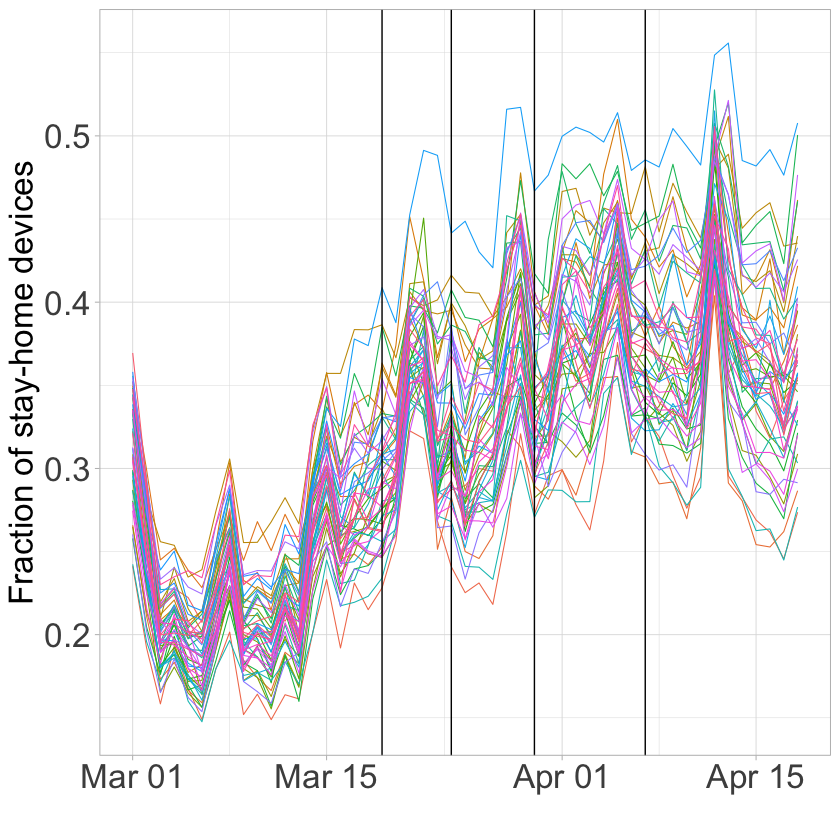

In [12]:
#####Plot the home_device_frac###

df_state <- df %>% group_by(state_abbv,ds) %>% summarise(home_device_frac=mean(home_device_frac))
head(df_state)
ggplot(data = df_state, aes(x = ds, y = home_device_frac, label =state_abbv))+ 
  geom_line(aes(color = state_abbv), size = 0.3, show.legend =F)+ 
geom_vline(xintercept=as.Date("2020-03-19"), color="black", size=0.4)+
geom_vline(xintercept=as.Date("2020-03-24"), color="black", size=0.4)+
geom_vline(xintercept=as.Date("2020-03-30"), color="black", size=0.4)+
geom_vline(xintercept=as.Date("2020-04-07"), color="black", size=0.4)+
theme_light()+
labs(x = "", y = "Fraction of stay-home devices") +
  #scale_color_viridis(option = "E",direction = 1+
  theme(axis.text=element_text(size=20),
        axis.title=element_text(size=20))


[1] "Date"

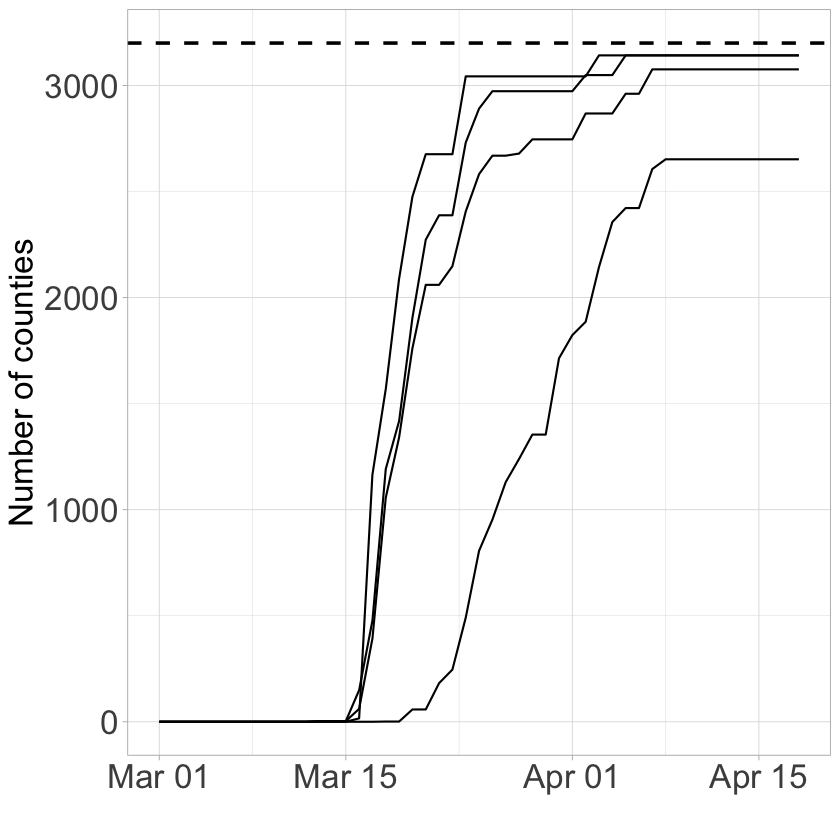

In [13]:
dates <- unique(df$ds)

dataset <- data.frame(ds=dates, n_stay_home=0,
                      n_gatherings50=0, n_gatherings500=0, n_schools=0, n_restaurants=0, n_gyms_movies=0)
#head(counties_long)

counties_long <- na.omit(counties_long)

class(dataset$ds)
for (i in c(1:nrow(dataset))){
    
    dataset$n_stay_home[i] = sum(counties_long$type=="stay_home" & counties_long$dt < dataset$ds[i])
    dataset$n_schools[i] = sum(counties_long$type=="schools" & counties_long$dt < dataset$ds[i])
    dataset$n_restaurants[i] = sum(counties_long$type=="restaurants" & counties_long$dt < dataset$ds[i])
    dataset$n_gyms_movies[i] = sum(counties_long$type=="gyms_movies" & counties_long$dt < dataset$ds[i])    
    
}

ggplot(data = dataset, aes(x = ds))+ 
geom_line(aes(y=n_stay_home), size = 0.6)+ 
geom_line(aes(y=n_schools), size = 0.6)+ 
geom_line(aes(y=n_restaurants), size = 0.6)+ 
geom_line(aes(y=n_gyms_movies), size = 0.6)+ 
geom_hline(yintercept = 3200, color="black", linetype="dashed", size=1)+
theme_light()+
labs(x = "", y = "Number of counties") +
  theme(axis.text=element_text(size=20),
        axis.title=element_text(size=20))